<a href="https://colab.research.google.com/github/baotram153/Reinforcement-Learning/blob/main/notebooks/Policy_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install gymnasium

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import gymnasium as gym
import time
from tqdm import tqdm

## Environment: Short Corridor

In [ ]:
class ShortCorridor:
    def __init__(self) -> None:
        self.terminal_states = [3]
        self.start_states = [0]
        self.state_space = np.arange(4)
        self.cur_state = np.random.choice(self.start_states)

    def reset(self):
        self.cur_state = np.random.choice(self.start_states)

    def get_reward (self):   # reward -1 per step
        return -1

    def take_action(self, action):
        if (self.cur_state == 1):
            if (action == 0):   # left
                self.cur_state += 1
            else:
                self.cur_state -= 1
        else:
            if (action == 0):
                self.cur_state -= 1
            else:
                self.cur_state += 1
        self.cur_state = max(min(self.cur_state, 3), 0)
        if (self.cur_state in self.terminal_states): terminated = True
        else: terminated = False
        return self.get_reward(), terminated

## Monte Carlo with Function Approximation


In [ ]:
class ValueFunction:    # build another feature construction class
    def __init__(self, n_features, alpha) -> None:
        self.params = np.zeros(n_features)
        self.feature_vectors = [[1,0], [0,1]]   # (s, left) & (s, right)
        self.alpha = alpha

    def get_state_action_value(self, state, action):
        pass

    def get_action_value (self, action):    # partially observable environemnt (don't know state)
        return np.dot(self.params, np.array(self.feature_vectors[action]))

    def update_value(self, action, delta):    # partially observable
        self.params += self.alpha*np.array(self.feature_vectors[action])*delta

In [ ]:
def Monte_Carlo_Control_with_Function_Approximation (n_eps, env, agent, gamma = 1):
    # return_of_start = []
    for ep in range(n_eps):
        env.reset()
        reward_vector = []
        action_vector = []
        while True:
            action = agent.get_action()
            reward, terminated = env.take_action(action)
            reward_vector.append(reward), action_vector.append(action)
            if (terminated): break
        return_val = 0
        for i in range(len(action_vector)):
            update_action = action_vector[-(i+1)]
            return_val = return_val + gamma*reward_vector[-(i+1)]
            delta = return_val - agent.get_action_value(update_action)
            agent.update_action_value(update_action, delta)
        # return_of_start.append(return_val)
        performance = agent.get_action_value(action_vector[0])
    # return np.mean(return_of_start)
    return performance

In [ ]:
def Monte_Carlo_Control_with_Function_Approximation_action_predefined (n_eps, env, agent, greedy_action, gamma = 1):
    for ep in range(n_eps):
        env.reset()
        reward_vector = []
        action_vector = []
        while True:
            if (greedy_action == 0):
                action = agent.get_left_action()
            else: action = agent.get_right_action()
            reward, terminated = env.take_action(action)
            reward_vector.append(reward), action_vector.append(action)
            if (terminated): break
        return_val = 0
        for i in range(len(action_vector)):
            update_action = action_vector[-(i+1)]
            return_val = return_val + gamma*reward_vector[-(i+1)]
            delta = return_val - agent.get_action_value(update_action)
            agent.update_action_value(update_action, delta)
        performance = agent.get_action_value(action_vector[0])
    return performance

## REINFORCE

In [ ]:
class PolicyGradient:
    def __init__(self, n_features, alpha) -> None:
        self.params = np.log([19, 1])
        # self.params = np.zeros(2)
        self.feature_vectors = [[1,0], [0,1]]
        self.alpha = alpha

    def get_action_preference (self, action):
        return np.dot(self.params, self.feature_vectors[action])

    def get_action_preference_vector (self, action_space):
        action_preferences = []
        for action in action_space:
            action_preferences.append(self.get_action_preference(action))
        return action_preferences

    def update (self, action, delta, action_space):
        action_preferences = self.get_action_preference_vector(action_space)
        exp_action_preferences = np.exp(action_preferences - np.max(action_preferences))
        action_softmax = exp_action_preferences[action]/ np.sum(exp_action_preferences)
        grad = 1 - action_softmax
        self.params[action] += self.alpha*delta*grad

In [ ]:
def Monte_Carlo_Control_with_Policy_Gradient (n_eps, env, agent, gamma = 1):    # REINFORCE
    returns_of_start = []
    for ep in range(n_eps):
        env.reset()
        reward_vector = []
        action_vector = []
        while True:
            action = agent.get_action()
            reward, terminated = env.take_action(action)
            reward_vector.append(reward), action_vector.append(action)
            if (terminated): break
        for i in range(len(action_vector)):
            update_action = action_vector[i]
            return_val = 0
            for j in range(i, len(action_vector)):
                return_val += gamma**(j-i)*reward_vector[j]
            delta = gamma**i*return_val
            agent.update_policy(update_action, delta)
            if (i == 0):
                returns_of_start.append(return_val)
    # print(returns_of_start)
    return returns_of_start

## REINFORCE with Baseline

In [ ]:
class StateValueFunction:    # build another feature construction class
    def __init__(self, n_features, alpha) -> None:  # 1 state
        self.params = np.zeros(n_features)
        self.alpha = alpha

    def get_state_value(self):
        return self.params

    def update_value(self, delta):    # partially observable
        self.params += self.alpha*delta

In [ ]:
def REINFORCE_with_Baseline (n_eps, env, agent, gamma = 1):
    returns_of_start = []
    for ep in range(n_eps):
        env.reset()
        reward_vector = []
        action_vector = []
        while True:
            action = agent.get_action()
            reward, terminated = env.take_action(action)
            reward_vector.append(reward), action_vector.append(action)
            if (terminated): break
        for i in range(len(action_vector)):
            update_action = action_vector[i]
            return_val = 0
            for j in range(i, len(action_vector)):
                return_val += gamma**(j-i)*reward_vector[j]
            delta = return_val - agent.get_state_value()
            agent.update_value(delta)
            agent.update_policy(update_action, gamma**(i)*delta)
            if (i == 0):
                returns_of_start.append(return_val)
    # print(returns_of_start)
    return returns_of_start

## Agent

In [ ]:
class ShortCorridorAgent:
    def __init__(self, value_func = None, epsilon = 0, policy_grad = None) -> None:
        self.action_space = [0, 1] # left, right
        self.value_func = value_func
        self.epsilon = epsilon
        self.policy_grad = policy_grad

    def get_action (self):
        if (self.policy_grad == None):
            if (np.random.rand() < self.epsilon):
                return np.random.choice (self.action_space)
            else:
                action_values = []
                for action in self.action_space:
                    action_values.append(self.value_func.get_action_value (action))
                return np.argmax(action_values)
        else:
            action_preferences = self.policy_grad.get_action_preference_vector(self.action_space)
            exp_action_preferences = np.exp(action_preferences)
            action_props = exp_action_preferences / np.sum(exp_action_preferences)
            # print(action_props)
            return np.random.choice(a= self.action_space, p= action_props)

    def get_left_action (self):
        if (np.random.rand() < self.epsilon):
            return np.random.choice(self.action_space)
        else: return 0

    def get_right_action (self):
        if (np.random.rand() < self.epsilon):
            return np.random.choice(self.action_space)
        else: return 1

    def get_action_value(self, action):
        return self.value_func.get_action_value(action)

    def get_action_value_vector (self):
        action_values = []
        for action in self.action_space:
            action_values.append(self.get_action_value(action))
        return action_values

    def get_state_value(self):
        # action_preferences = self.policy_grad.get_action_preference_vector(self.action_space)
        # exp_action_preferences = np.exp(action_preferences - np.max(action_preferences))
        # action_softmax = exp_action_preferences/ np.sum(exp_action_preferences)
        # action_values = self.get_action_value_vector()
        # return np.dot(action_softmax, action_values)
        return self.value_func.get_state_value()

    def update_action_value (self, action, delta):
        self.value_func.update_value(action, delta)

    def update_state_value (self, delta):
        self.value_func.update_value(delta)

    def update_policy (self, action, delta):
        self.policy_grad.update(action, delta, self.action_space)

## Run experiment

In [ ]:
def experiment1 (n_eps, n_runs, algorithm, alphas):
    y = []
    for alpha in alphas:
        total_returns = []
        for run in tqdm(range(n_runs)):
            total_return = algorithm(n_eps= n_eps, env= ShortCorridor(), agent=ShortCorridorAgent(policy_grad=PolicyGradient(2, alpha)), gamma= 1)
            total_returns.append(total_return)
        y.append(np.mean(total_returns, axis= 0))
    return y

def experiment2 (n_eps, n_runs, algorithm, value_alphas, policy_alphas):
    y = []
    for i in range (len(value_alphas)):
        total_returns = []
        for run in tqdm(range(n_runs)):
            total_return = algorithm(n_eps= n_eps, env= ShortCorridor(), agent=ShortCorridorAgent(value_func= StateValueFunction(1, value_alphas[i]), policy_grad=PolicyGradient(2, policy_alphas[i])), gamma= 1)
            total_returns.append(total_return)
        y.append(np.mean(total_returns, axis= 0))
    return y

### Monte Carlo with Function Approximation

In [ ]:
# epsilon-greedy right
total_return = Monte_Carlo_Control_with_Function_Approximation(n_eps=10000, env=ShortCorridor(), agent=ShortCorridorAgent(ValueFunction(2, 10**(-4)), epsilon= 0.1), gamma = 1)
print(total_return)

-44.96764911143542


In [ ]:
# epsilon-greedy left
total_return = Monte_Carlo_Control_with_Function_Approximation_action_predefined (n_eps=10000, env=ShortCorridor(), agent=ShortCorridorAgent(ValueFunction(2, 10**(-3)), epsilon= 0.1), greedy_action = 0, gamma = 1)
print(total_return)

-82.79740510282993


In [ ]:
# epsilon-greedy right
total_return = Monte_Carlo_Control_with_Function_Approximation_action_predefined(n_eps=10000, env=ShortCorridor(), agent=ShortCorridorAgent(ValueFunction(2, 10**(-3)), epsilon= 0.1), greedy_action = 1, gamma = 1)
print(total_return)

-44.662326768411816


### REINFORCE

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


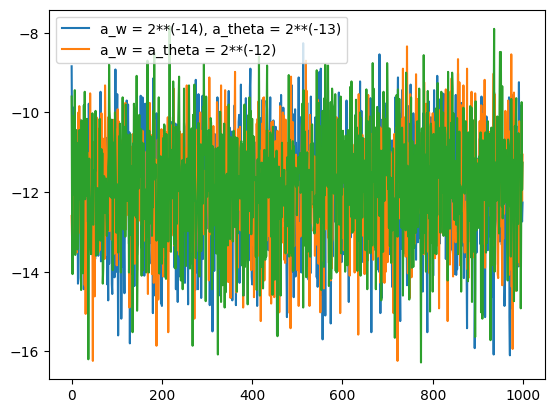

In [ ]:
n_eps = 1000
n_runs = 50
algorithm = Monte_Carlo_Control_with_Policy_Gradient
alphas = [2**(-14), 2**(-13), 2**(-12)]
y = experiment1 (n_eps, n_runs, algorithm, alphas)
for i in range (len(y)):
    plt.plot(range(n_eps), y[i])
    plt.legend(['a_w = 2**(-14), a_theta = 2**(-13)', 'a_w = a_theta = 2**(-12)'])
plt.show()


100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


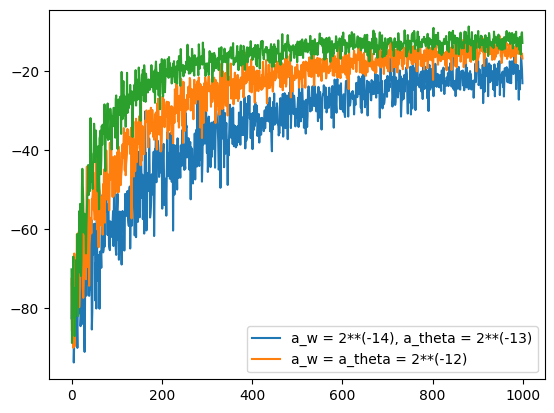

In [ ]:
n_eps = 1000
n_runs = 50
algorithm = Monte_Carlo_Control_with_Policy_Gradient
alphas = [2**(-14), 2**(-13), 2**(-12)]
y = experiment1 (n_eps, n_runs, algorithm, alphas)
for i in range (len(y)):
    plt.plot(range(n_eps), y[i])
    plt.legend(['a_w = 2**(-14), a_theta = 2**(-13)', 'a_w = a_theta = 2**(-12)'])
plt.show()

### REINFORCE with Baseline

100%|██████████| 50/50 [02:32<00:00,  3.05s/it]


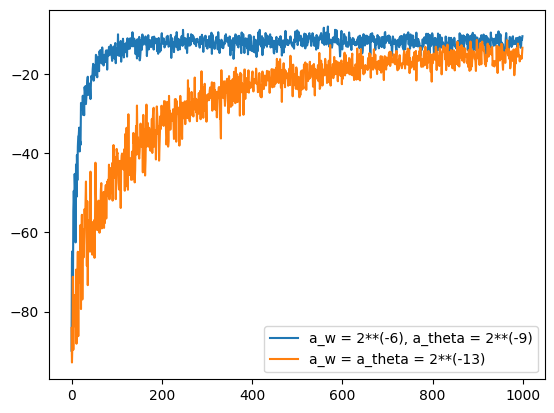

In [ ]:
n_eps = 1000
n_runs = 50
algorithm = REINFORCE_with_Baseline
y = experiment2 (n_eps, n_runs, algorithm, value_alphas= [2**(-6), 2**(-13)], policy_alphas= [2**(-9), 2**(-13)])
for i in range (len(y)):
    plt.plot(range(n_eps), y[i])
    plt.legend(['a_w = 2**(-6), a_theta = 2**(-9)', 'a_w = a_theta = 2**(-13)'])
plt.show()